### Import libraries and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_regression
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier

### Load data

The dataset is loaded and subjected to preliminary visualization. The sample distribution across each 'Quality_Label' level is verified, ensuring no duplicate entries or missing values (NA) are present.

In [2]:
df = pd.read_csv("../data/balanced_cinnamon_quality_dataset.csv")

In [3]:
print(f'Number of samples {df.shape[0]}')
print(f'Number of features {df.shape[1]}')
df.head()

Number of samples 60
Number of features 8


,Sample_ID,Moisture (%),Ash (%),Volatile_Oil (%),Acid_Insoluble_Ash (%),Chromium (mg/kg),Coumarin (mg/kg),Quality_Label
0,H001,10.56,5.93,1.24,0.28,0.0019,0.0021,High
1,H002,11.43,5.60,1.35,0.25,0.0016,0.0039,High
2,H003,11.10,5.70,1.21,0.37,0.0013,0.0029,High
3,H004,10.90,5.76,1.47,0.27,0.0011,0.0035,High
4,H005,10.23,5.82,1.28,0.26,0.0013,0.0047,High


In [4]:
# Target feature distribution
df['Quality_Label'].value_counts()

Quality_Label
High      20
Medium    20
Low       20
Name: count, dtype: int64

In [5]:
# Duplicated samples
any(df['Sample_ID'].value_counts() > 1)

False

In [6]:
# NA values by features
df.isna().sum()

Sample_ID                 0
Moisture (%)              0
Ash (%)                   0
Volatile_Oil (%)          0
Acid_Insoluble_Ash (%)    0
Chromium (mg/kg)          0
Coumarin (mg/kg)          0
Quality_Label             0
dtype: int64

### Exploratory features analysis

An exploratory analysis of the predictor variables is performed. For this purpose, the distribution of values for each variable and pairwise correlation are used.

In [7]:
features = list(filter(lambda x: x not in ['Sample_ID', 'Quality_Label'],  list(df.columns)))

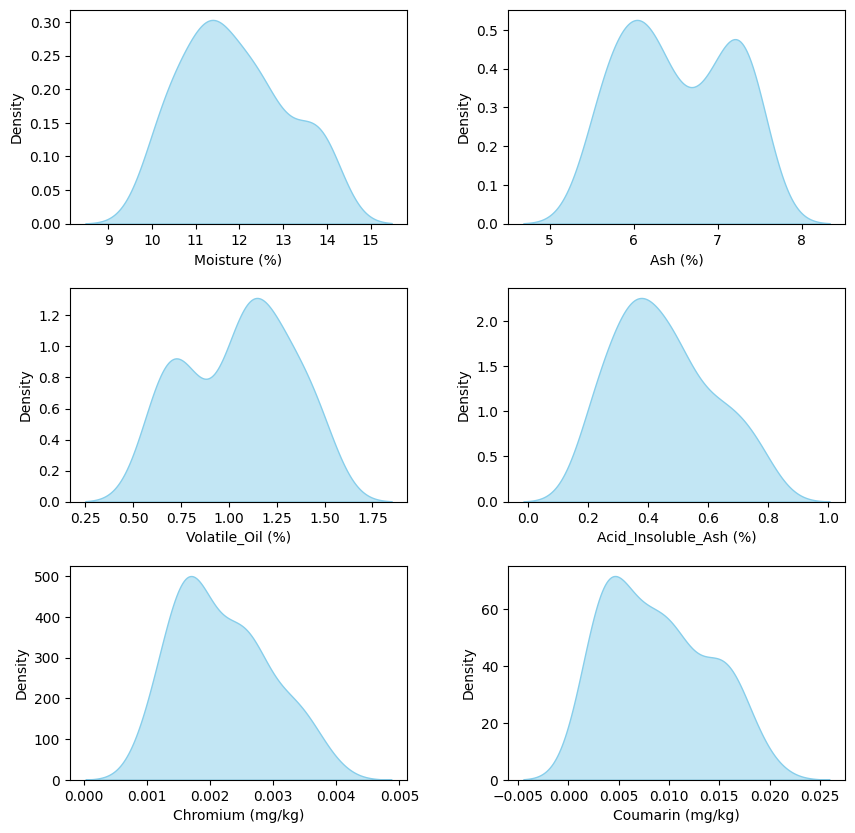

In [8]:
# Density plot each feature
plt.figure(figsize=(10, 10))  # Dynamic figure size
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for i, feature in enumerate(features,start=1):
    plt.subplot(3, 2, i)
    sns.kdeplot(df[feature], fill=True, color='skyblue', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.show()


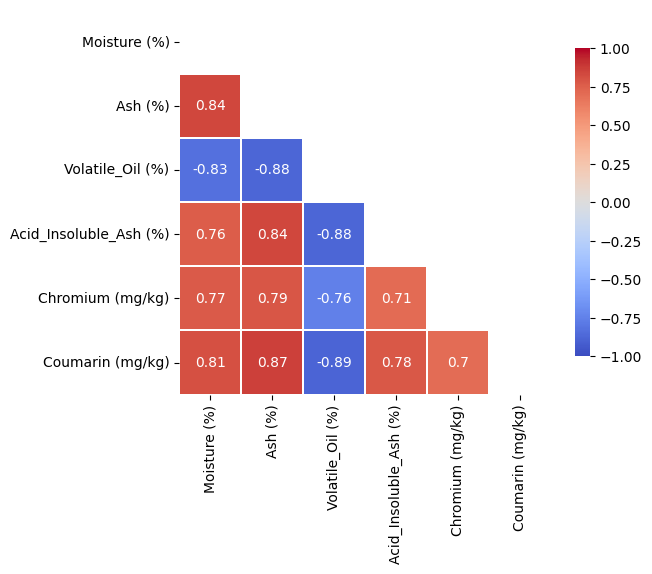

In [9]:
# Correlation between features
corr = df[features].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(corr, mask=mask,
            vmin = -1.0, vmax=1.0, center=0.0,
            linewidths=.1, cmap="coolwarm", 
            cbar_kws={"shrink": .8},
            annot = True)

plt.show()

### Correlation with target

The relationship between predictor variables and the target is also analyzed using violin plots and ANOVA tests. Through the F-test values, we can assess the potencial of variables for classification.

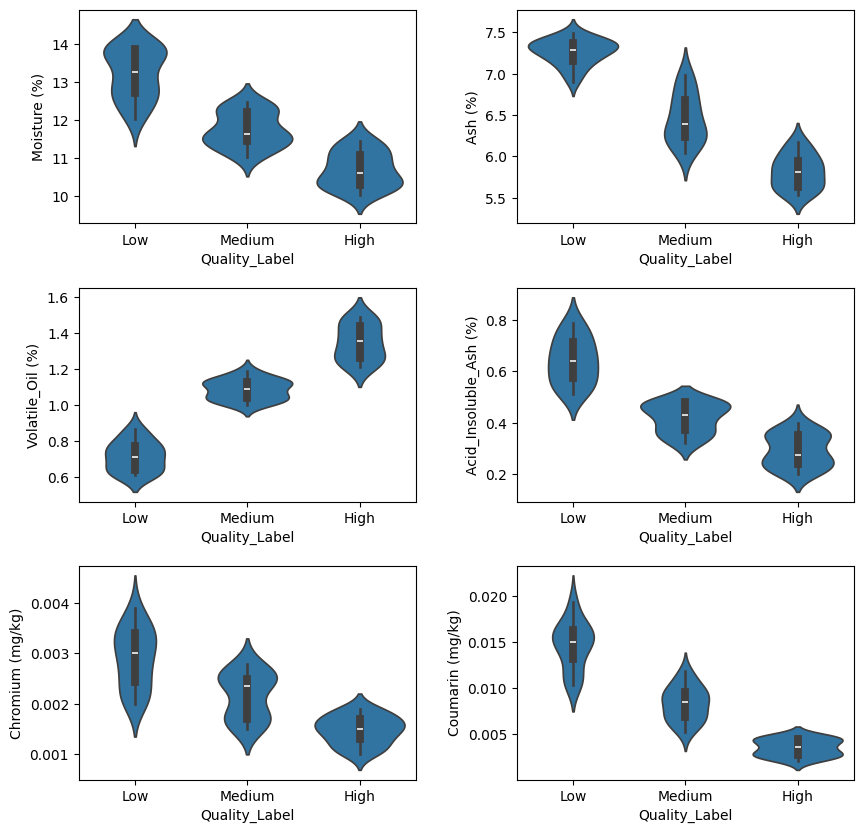

In [10]:
# Violin plot each feature (+ boxplot)
plt.figure(figsize=(10, 10))  # Dynamic figure size
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
for i, feature in enumerate(features,start=1):
    plt.subplot(3, 2, i)
    sns.violinplot(x = "Quality_Label", y = feature, data = df, 
                   inner = "box", order=['Low', 'Medium', 'High'])
plt.show()

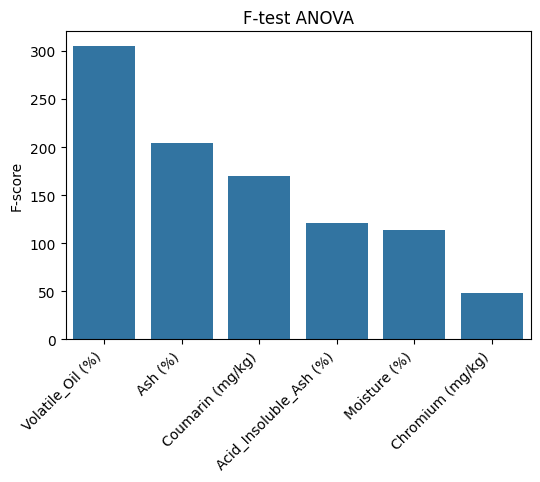

In [11]:
# ANOVA test
plt.figure(figsize=(6, 4))  # Dynamic figure size
f_scores, p_values = f_classif(df[features], df["Quality_Label"])
df_anova = pd.DataFrame({'feature': features, 'f_score': f_scores}).sort_values('f_score',ascending=False)
features_anova = list(df_anova['feature'])
sns.barplot(x='feature', y='f_score', data=df_anova)
plt.xlabel('')
plt.xticks(rotation=45, ha = 'right')
plt.ylabel('F-score')
plt.title('F-test ANOVA')
plt.show()

The 'Volatile Oil' feature has by far the highest classification potential among all features. 'Ash' and 'Coumarin' are the next most significant features with predictive power after 'Volatile Oil'. The correlation between features is high, exceeding an absolute value of 0.80 in most cases. 'Chromium' variable shows the lowest correlation with the other variables, suggesting it may contain different information about the target. However, it should also be noted that this is the variable with the lowest classification potential according to the F-test values.

### Feature selection

At this stage, given that we have several variables with high predictive power, building a 100% accurate model using all of them would be straightforward. The real challenge lies in determining how far we can push feature selection to develop the simplest possible model using the fewest variables. This approach would be particularly attractive for companies looking to reduce costs in their analytical processes—fewer variables for classification would automatically mean fewer required analyses, leading to immediate cost reductions. We define our objective here as finding the simplest possible model capable of classifying samples with 100% accuracy.

#### Volatile Oil feature as discriminant

As can be seen in the following plot, based on the available data, 'Volatile Oil' could serve as a discriminant feature for sample classification. This parameter enables the definition of two discriminatory thresholds for flawless sample classification. The low-quality threshold would correspond to the average of maximum values observed in the low-quality group and the minimum value from the intermediate-quality group. Samples falling below this cutoff would be categorically classified as low quality. Analogously, a second threshold could be derived to differentiate high-quality and intermediate-quality specimens.

Discriminant feature: Volatile_Oil (%)
	Low Quality: Volatile Oil (%) < 0.935
	Medium Quality: 0.935 < Volatile Oil (%) < 1.2
	High Quality: Volatile Oil (%) < 1.2


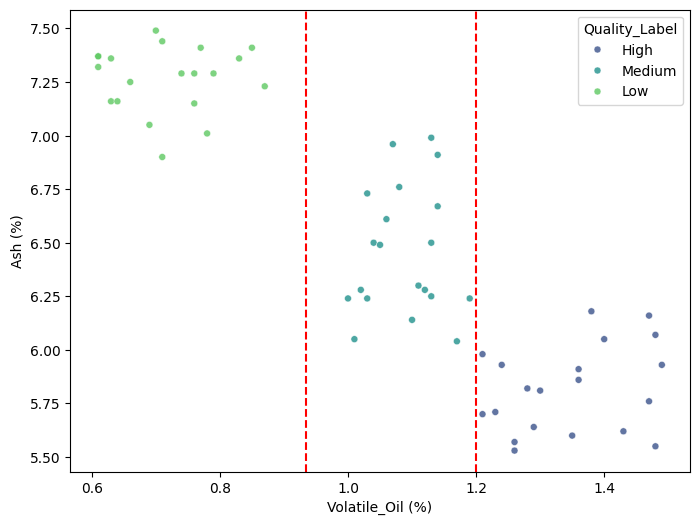

In [12]:
# build thresholds for classification
df_agg = df.groupby('Quality_Label')['Volatile_Oil (%)'].agg(['mean','min','max'])
low_medium = (df_agg['max']['Low'] + df_agg['min']['Medium'])/2
medium_high = (df_agg['max']['Medium'] + df_agg['min']['High'])/2
print('Discriminant feature: Volatile_Oil (%)')
print(f'\tLow Quality: Volatile Oil (%) < {low_medium}')
print(f'\tMedium Quality: {low_medium} < Volatile Oil (%) < {medium_high}')
print(f'\tHigh Quality: Volatile Oil (%) < {medium_high}')

# plot volatile_oil versus ash
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Volatile_Oil (%)', y='Ash (%)', hue='Quality_Label', 
                data=df, palette='viridis', 
                s=25, alpha=0.8)
plt.axvline(x=low_medium, color='r', linestyle='--', label='Vertical Line')
plt.axvline(x=medium_high, color='r', linestyle='--', label='Vertical Line')
plt.show()


The classification of low-quality samples seems more reliable, as the separation between low-quality samples and the rest is clear. What doesn't seem as reliable is the differentiation between high-quality and medium-quality samples.

To test the robustness of this model, 100 train-test splits will be generated, and the model's predictive performance will be evaluated on these different datasets using accuracy, precision and recall.

In [13]:
# Generate random train and test dataset
from itertools import combinations
import random

comb = combinations(list(range(20)), 6)
lst = list(comb)
rnd = random.sample(lst, 300)

lst_pos = []
for i in range(0,300,3):
    lst_pos.append(list(rnd[i]) + list(map(lambda x: x + 20, list(rnd[i+1]))) + list(map(lambda x: x + 40, list(rnd[i+2]))))

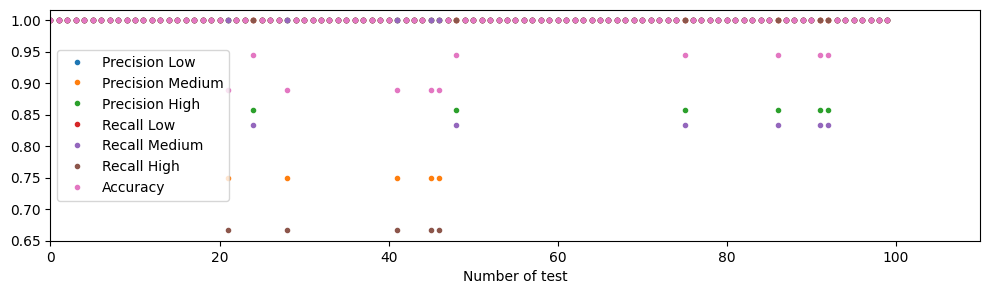

In [14]:
# Classification using Volatile Oil (%) discrimination
acc_volatile = []
precision = []
recall = []
for pos in lst_pos:
    # build data train
    mask = np.ones(len(df), dtype=bool)
    mask[pos] = False
    df_train = df.iloc[mask]
    # build data test
    df_test = df.iloc[pos]
    # calculate low_medium train and medium_high train
    df_agg = df_train.groupby('Quality_Label')['Volatile_Oil (%)'].agg(['min','max'])
    low_medium = (df_agg['max']['Low'] + df_agg['min']['Medium'])/2
    medium_high = (df_agg['max']['Medium'] + df_agg['min']['High'])/2
    # predict test
    y_pred = list(map(lambda x: "High" if x > medium_high else ("Medium" if x > low_medium else "Low"), df_test['Volatile_Oil (%)']))
    y = df_test['Quality_Label']
    # accuracy
    precision.append(precision_score(y, y_pred, average=None, labels = ['Low', 'Medium', 'High']))
    recall.append(recall_score(y, y_pred, average=None, labels = ['Low', 'Medium', 'High']))
    acc_volatile.append(accuracy_score(y, y_pred))

df_precision = pd.DataFrame(np.array(precision))
df_precision.columns = ['Precision Low', 'Precision Medium', 'Precision High']
df_recall = pd.DataFrame(np.array(recall))
df_recall.columns = ['Recall Low', 'Recall Medium', 'Recall High']
df_stats = pd.concat([df_precision, df_recall], axis = 1)
df_stats['Accuracy'] = acc_volatile

df_stats.plot(marker='o', markersize=3, linestyle = 'None', figsize = (12,3))
plt.xlabel("Number of test")
plt.xlim(0,110)
plt.show()

The previous plot displays the accuracy (micro-average precision), and precision and recall for each class using 'Volatile Oil' as discriminant over the 100 train-test splits. This model cannot correctly classify all samples across all tests. Classification errors occur specifically in the Medium and High groups. However, for all tests performed, all samples labeled as Low are properly classified (Recall Low  100%) and false positives does not appear for Low label (Precision Low 100%).

#### Logistic regression for selected features 

As previously noted, the available data makes it straightforward to achieve a model with 100% accuracy. The real challenge now is to develop the simplest possible model using the minimal set of features. Given these premises—and considering the previous model’s inability to achieve perfect classification—we will test multiple logistic regression models with different feature combinations.

Feature selection will be guided by the predictive power analyzed in the 'Correlation with Target' section and inter-feature correlation. Three models will be evaluated considering different combinations of features.  The simplest model uses the two most predictive features ('Volatile Oil' and 'Ash'). The other two models incorporate one additional variable: either the third most predictive feature ('Coumarin') or 'Chromium' variable. While 'Chromium' has limited predictive power, its low correlation with other features makes it worth evaluating for potential added information.

The robustness of these models was also verified using the 100 train-test splits generated previously.

In [15]:
def logreg_y_test_pred(df_train, df_test, features):
    """
    Train a logistic regression model on standardized features and predict test set labels.
    """
    X_train = df_train[features]
    y_train = df_train['Quality_Label']
    X_test = df_test[features]
    y_test = df_test['Quality_Label']
    # Standarizate train (fit + transform)
    # Standarizate test (transform)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Regression train (fit)
    # Regression test (predict)
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)
    # Predict on test set
    y_test_pred = logreg.predict(X_test_scaled)
    return y_test_pred

def logreg_accuracy(df, lst_pos, features, target):
    """
    Calculate logistic regression accuracy for leave-one-out cross-validation on specified positions.
    """
    acc = []
    for pos in lst_pos:
        # build data train
        mask = np.ones(len(df), dtype=bool)
        mask[pos] = False
        df_train = df.iloc[mask]
        df_test = df.iloc[pos]
        y_test = df_test[target]
        y_test_pred = logreg_y_test_pred(df_train, df_test, features)
        acc.append(accuracy_score(y_test, y_test_pred))
    return acc

def acc_prop(acc):
    """
    Calculate the proportion of accuracy values rounded to 2 decimal places.
    """
    acc_clean = list(map(lambda x: round(x,2),acc))
    counts = pd.Series(acc_clean).value_counts()/100
    return counts

In [16]:
# log regression for 100 train-test split
experiments = {
               'Log. Regr. Volatile Oil + Ash': ['Volatile_Oil (%)', 'Ash (%)'],
               'Log. Regr. Volatile Oil + Ash + Chromium': ['Volatile_Oil (%)', 'Ash (%)', 'Chromium (mg/kg)'],
               'Log. Regr. Volatile Oil + Ash + Coumarin': ['Volatile_Oil (%)', 'Ash (%)', 'Coumarin (mg/kg)']
              }

lst_prop = []
for name_experiemnt, features in experiments.items():
    accuracy = logreg_accuracy(df, lst_pos, features, 'Quality_Label')
    lst_prop.append(acc_prop(accuracy))

prop_volatile = acc_prop(acc_volatile)

df_acc = pd.concat([prop_volatile] + lst_prop, axis=1, join="outer")
columns_name = ["Discriminant Volatile Oil"] + list(experiments.keys())
df_acc.columns = columns_name

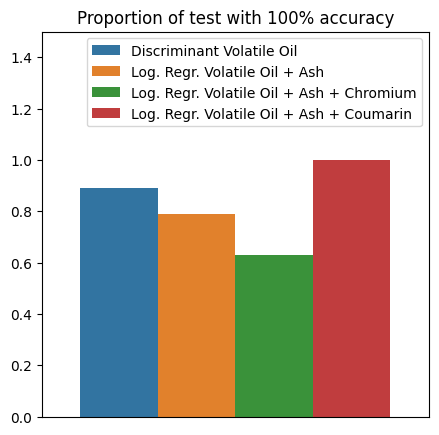

In [17]:
# show results
df_melted = df_acc.reset_index().melt(id_vars='index', var_name='Experiment', value_name='Proportion')
sort_acc = sorted(list(df_melted["index"]), reverse=True)
plt.figure(figsize = (5,5))
sns.barplot(x = 'index', y = 'Proportion', hue = 'Experiment', 
            data = df_melted[df_melted['index']==1.0],
            hue_order = columns_name)
plt.ylim(0,1.5)
plt.legend(title=None)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.title('Proportion of test with 100% accuracy')
plt.show()

### Conclusions

The simplest model in this study uses 'Volatile Oil' as the discriminant variable for sample classification. While this model lacks robustness for classifying all three sample types, it effectively discriminates between Low-quality samples and all others.

To achieve a robust classifier for all three categories, the model must incorporate the features with the highest predictive power ('Volatile Oil', 'Ash', and 'Coumarin'). Although 'Chromium' exhibits low correlation with other variables, it fails to contribute meaningful information when combined with 'Volatile Oil' and 'Ash', resulting in insufficient model robustness.